## Gene TSS counts

In [163]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

sys.path.append('/home/camiel/chromograph/')
# from chromograph.plotting.UMI_plot import UMI_plot
import chromograph
from chromograph.peak_calling.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [164]:
## Import path to the relevant 10X reference dataset

ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-mm10-1.2.0'
indir = '/data/proj/scATAC/chromograph/mouse_test2/'
f = os.path.join(indir, '10X_test_10kb.loom')

pad = 1000

In [165]:
## Connect to loompy session
ds = loompy.connect(f)
logging.info(ds.shape)

13:21:34 INFO     (271145, 4273)


In [2]:
%who

Interactive namespace is empty.


In [166]:
tss = BedTool(os.path.join(ref, 'regions', 'tss.bed'))
print(len(tss))
tss.head()

74258
chr1	3073252	3073253	RP23-271O17.1	.	+	TEC
 chr1	3102015	3102016	Gm26206	.	+	snRNA
 chr1	3252756	3252757	RP23-317L18.1	.	+	processed_pseudogene
 chr1	3368548	3368549	RP23-317L18.4	.	-	TEC
 chr1	3377787	3377788	RP23-317L18.3	.	-	TEC
 chr1	3466586	3466587	RP23-115I1.1	.	+	antisense
 chr1	3467284	3467285	RP23-115I1.6	.	-	TEC
 chr1	3514506	3514507	RP23-115I1.5	.	-	TEC
 chr1	3531794	3531795	RP23-115I1.2	.	+	processed_pseudogene
 chr1	3595902	3595903	RP23-115I1.3	.	-	TEC
 

In [176]:
coding = []

for x in tss:
    if x[6] == 'protein_coding':
        coding.append(x)

coding = BedTool(coding)
coding = coding.slop(b=pad, genome = ds.attrs['reference_assembly'])
coding_collaps = coding.groupby(g = [4,1], c = [2,3,4], o = ['min', 'max', 'count'], full=True)
coding_collaps.head()

chr1	3670497	3672498	Xkr4	.	-	protein_coding	3670497	3672498	1
 chr1	4359313	4361314	Rp1	.	-	protein_coding	4359313	4410241	3
 chr1	4495362	4497363	Sox17	.	-	protein_coding	4495362	4498354	4
 chr1	4784709	4786710	Mrpl15	.	-	protein_coding	4784709	4786739	2
 chr1	4806822	4808823	Lypla1	.	+	protein_coding	4806822	4808830	2
 chr1	4806891	4808892	RP24-426M1.3	.	+	protein_coding	4806891	4808892	1
 chr1	4806895	4808896	Lypla1	.	+	protein_coding	4806895	4808911	2
 chr1	4856813	4858814	Tcea1	.	+	protein_coding	4856813	4859038	2
 chr1	5017734	5019735	Rgs20	.	-	protein_coding	5017734	5020539	2
 chr1	5069017	5071018	Atp6v1h	.	+	protein_coding	5069017	5071018	1
 

In [177]:
## Remove genes with non-unique names occuring on multiple chromosomes

tmp = []
for x in coding_collaps:
    tmp.append(x[3])
    
print(len(tmp), len(np.unique(tmp)))

mults = collections.Counter(tmp)
fix = []

for k in mults:
    if mults[k] > 1:
        fix.append(k)
        
newcoding=[]
for x in coding:
    if x[3] in fix:
        continue
    else:
        newcoding.append(x)
    
coding = BedTool(newcoding)
coding_collaps = coding.groupby(g = [4,1], c = [2,3,4], o = ['min', 'max', 'count'], full=True)
len(coding_collaps)

22518 21967


21439

In [178]:
            
def feature_count(data, coding, res):
    '''
    temporary
    '''    
    counts = coding.intersect(BedTool(data[1]), c=True)
    counts = np.array([int(x[7]) for x in counts])
    
    genes = []
    for x in coding:
        genes.append(x[3])
      
    count_dict = {}
    sel = counts > 0
    for k, v in zip(np.array(genes)[sel], counts[sel]):
        if k not in count_dict:
            count_dict[k] = v
        else:
            count_dict[k] += v
    
    res[data[0]] = count_dict
    return

In [179]:
genes = []
for x in coding:
    genes.append(x[3])

In [180]:
genes = []
for x in coding:
    genes.append(x[3])

res = {}

## Chunk by cell
frags = [strFrags_to_list(x) for x in ds.ca['fragments']]
chunks = [[k,v] for k,v in zip(ds.ca['cell_id'], frags)]

logging.info(f"Chunked data")

13:31:54 INFO     Chunked data


In [181]:
i = 0
logging.info(f"Started counting genes")
for chunk in chunks:
        feature_count(chunk, coding, res)
        
        i += 1
        
        if i%300 == 0:
            logging.info(f"processed {i} cells")

13:31:54 INFO     Started counting genes
13:43:02 INFO     processed 300 cells
13:54:17 INFO     processed 600 cells
14:05:40 INFO     processed 900 cells
14:17:01 INFO     processed 1200 cells
14:28:31 INFO     processed 1500 cells
14:41:20 INFO     processed 1800 cells
14:54:11 INFO     processed 2100 cells
15:07:01 INFO     processed 2400 cells
15:19:55 INFO     processed 2700 cells
15:32:56 INFO     processed 3000 cells
15:46:02 INFO     processed 3300 cells
15:59:05 INFO     processed 3600 cells
16:12:14 INFO     processed 3900 cells
16:25:23 INFO     processed 4200 cells


In [182]:
rows = {'Gene': [], 'N_TSS': []}

for x in coding_collaps:
    rows['Gene'].append(x[3])
    rows['N_TSS'].append(x[9])
    
logging.info(f"Extracted coding genes to dict")

g_ref = {}
for x,k in enumerate(rows['Gene']):
    g_ref[k] = x

16:28:33 INFO     Extracted coding genes to dict


In [183]:
print(len(genes), len(np.unique(genes)), len(coding_collaps))

SyntaxError: unexpected EOF while parsing (<ipython-input-183-334655d1bb62>, line 1)

In [113]:
## Create sparse matrix
col = []
row = []
val = []

cix = 0
for cell in res:
    
    for key in res[cell]:
        col.append(cix)
        row.append(g_ref[key])
        val.append(res[cell][key])
    cix+=1
    
matrix = sparse.coo_matrix((val, (row,col)), shape=(len(rows['Gene']), len(ds.ca['cell_id'])))
matrix

<22518x4273 sparse matrix of type '<class 'numpy.int64'>'
	with 18356269 stored elements in COOrdinate format>

In [125]:
dsg.close()

In [124]:
f_out = f.split('_')[:-1]
f_out = '_'.join(f_genes) + "_tss.loom"

col_attrs = dict(ds.ca)
f_attrs = dict(ds.attrs)

loompy.create(filename=f_out, 
              layers=matrix, 
              row_attrs=rows, 
              col_attrs=col_attrs,
              file_attrs=f_attrs)

In [126]:
dsg = loompy.connect(f_out)
dsg.shape

(22518, 4273)

In [ ]:
## Smoothing matrix

##

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

def feature_plot(ds: loompy.LoomConnection, out_file: str, markers : list, embedding: str = "TSNE") -> None:
    '''
    Generates a multi-panel plot to inspect UMI and Bin counts.
    
    Args:
        ds                    Connection to the .loom file to use
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    

    Ylen = np.ceil(len(markers) / 3)
    
    fig = plt.figure(figsize=(Ylen*7, 21))
    fig.subplots_adjust(hspace=.1, wspace=.1)
    
    
    for i in range(1, len(markers) + 1):
        ax = fig.add_subplot(Ylen, 3, i)
    
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        gene = markers[i-1]
        exp = np.log1p(ds[ds.ra['Gene'] == gene,:].flatten())
#         exp = ds[ds.ra['Gene'] == gene,:].flatten()
        k = exp > 0
            
        ax.scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], c='lightgrey', marker='.', lw=0, s=epsilon)
        im = ax.scatter(ds.ca[embedding][k,0],ds.ca[embedding][k,1], c=exp[k], cmap='viridis', marker='.', lw=0, s=epsilon+1)

        fig.colorbar(im, orientation='vertical', ax=ax)
        ax.set_title(f"{gene}")
        ax.axis("off")
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

In [135]:
print(len(dsg.ra['Gene']))
print(len(np.unique(dsg.ra['Gene'])))
print(len(rows['Gene']))

22518
21967
22518


In [128]:
markers = ['Otx2', 'Snap25', 'Gad2', 'Igfbp2', 'C1qb', 'Reln', 'Neurod6', 'Apoe', 'Gfap', 'Aqp4', 'Olig2', 'Plp1']

In [131]:
dsg.ca['TSNE'].shape

(4273, 2)

In [129]:
f_plot = f.split('_')[:-1]
f_TSNE = '_'.join(f_plot) + '_genes_tSNE.png'
f_UMAP = '_'.join(f_plot) + '_genes_UMAP.png'

feature_plot(dsg, f_TSNE, dsg.ra['Gene'], embedding = 'TSNE')
feature_plot(dsg, f_UMAP, dsg.ra['Gene'], embedding = 'UMAP')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4273 but corresponding boolean dimension is 8546

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2b432ed7f9e0> (for post_execute):


ValueError: Image size of 3783024x1512 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 3783024x1512 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 3.78302e+06x1512 with 9 Axes>

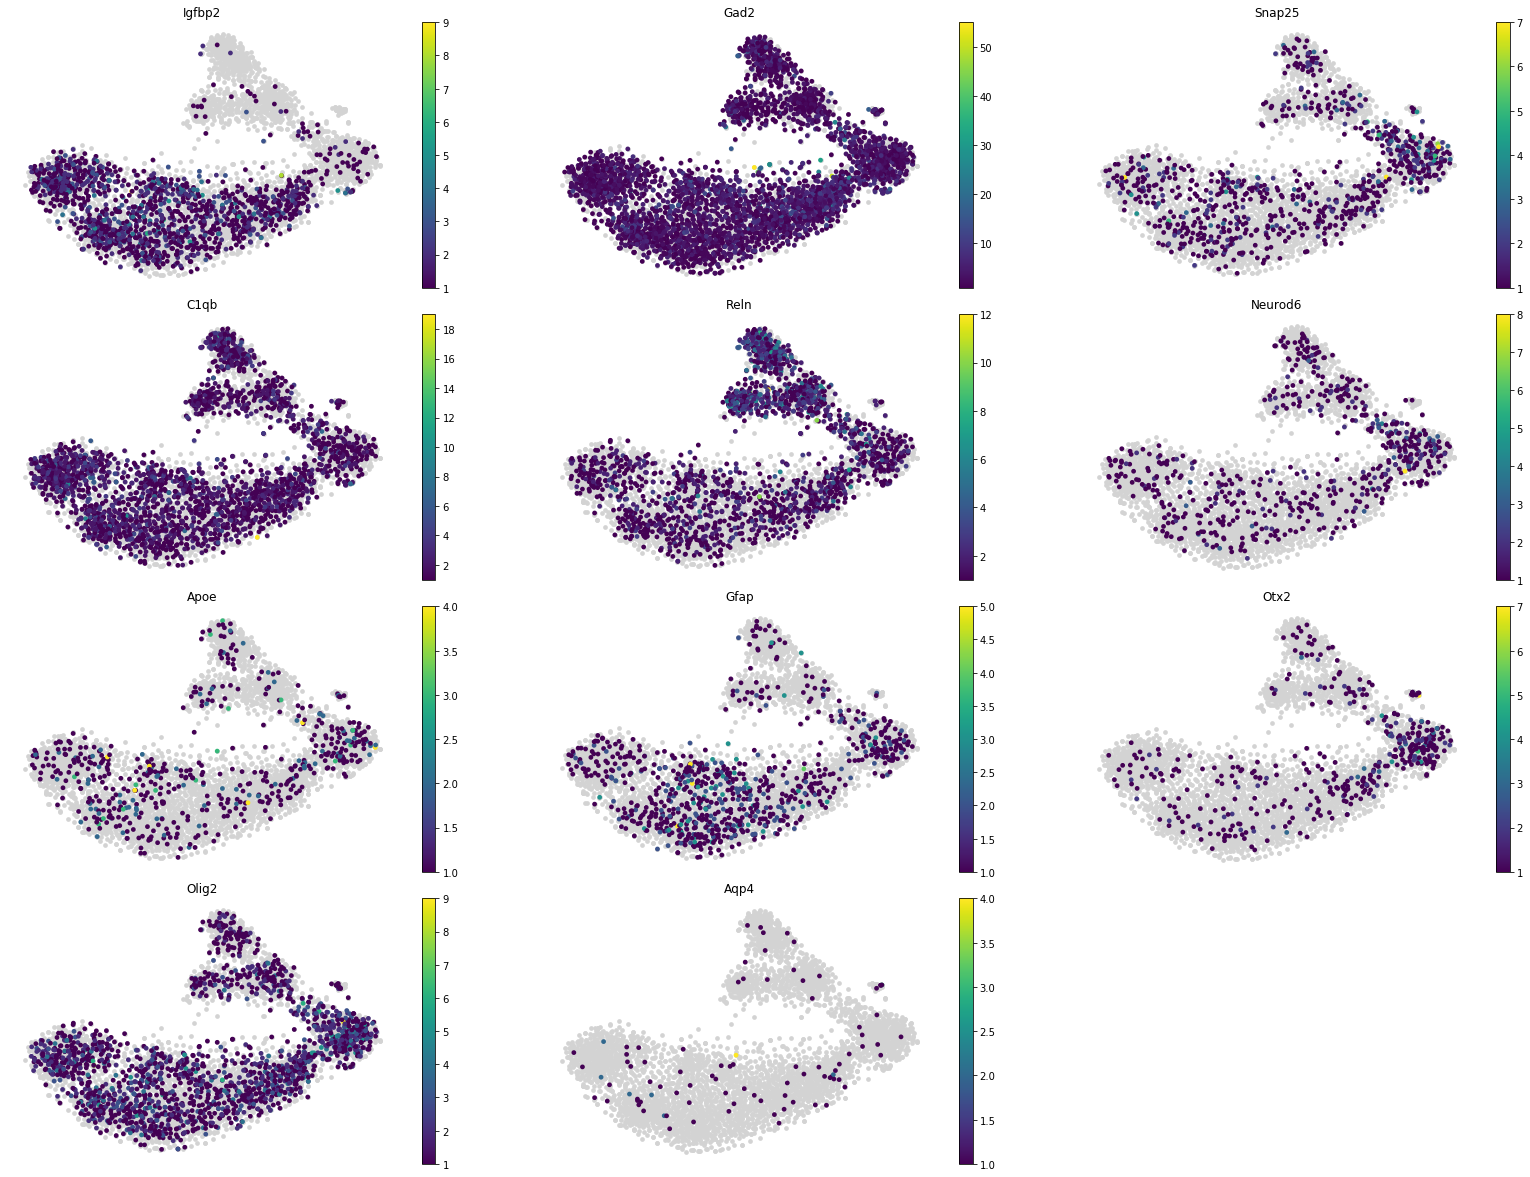

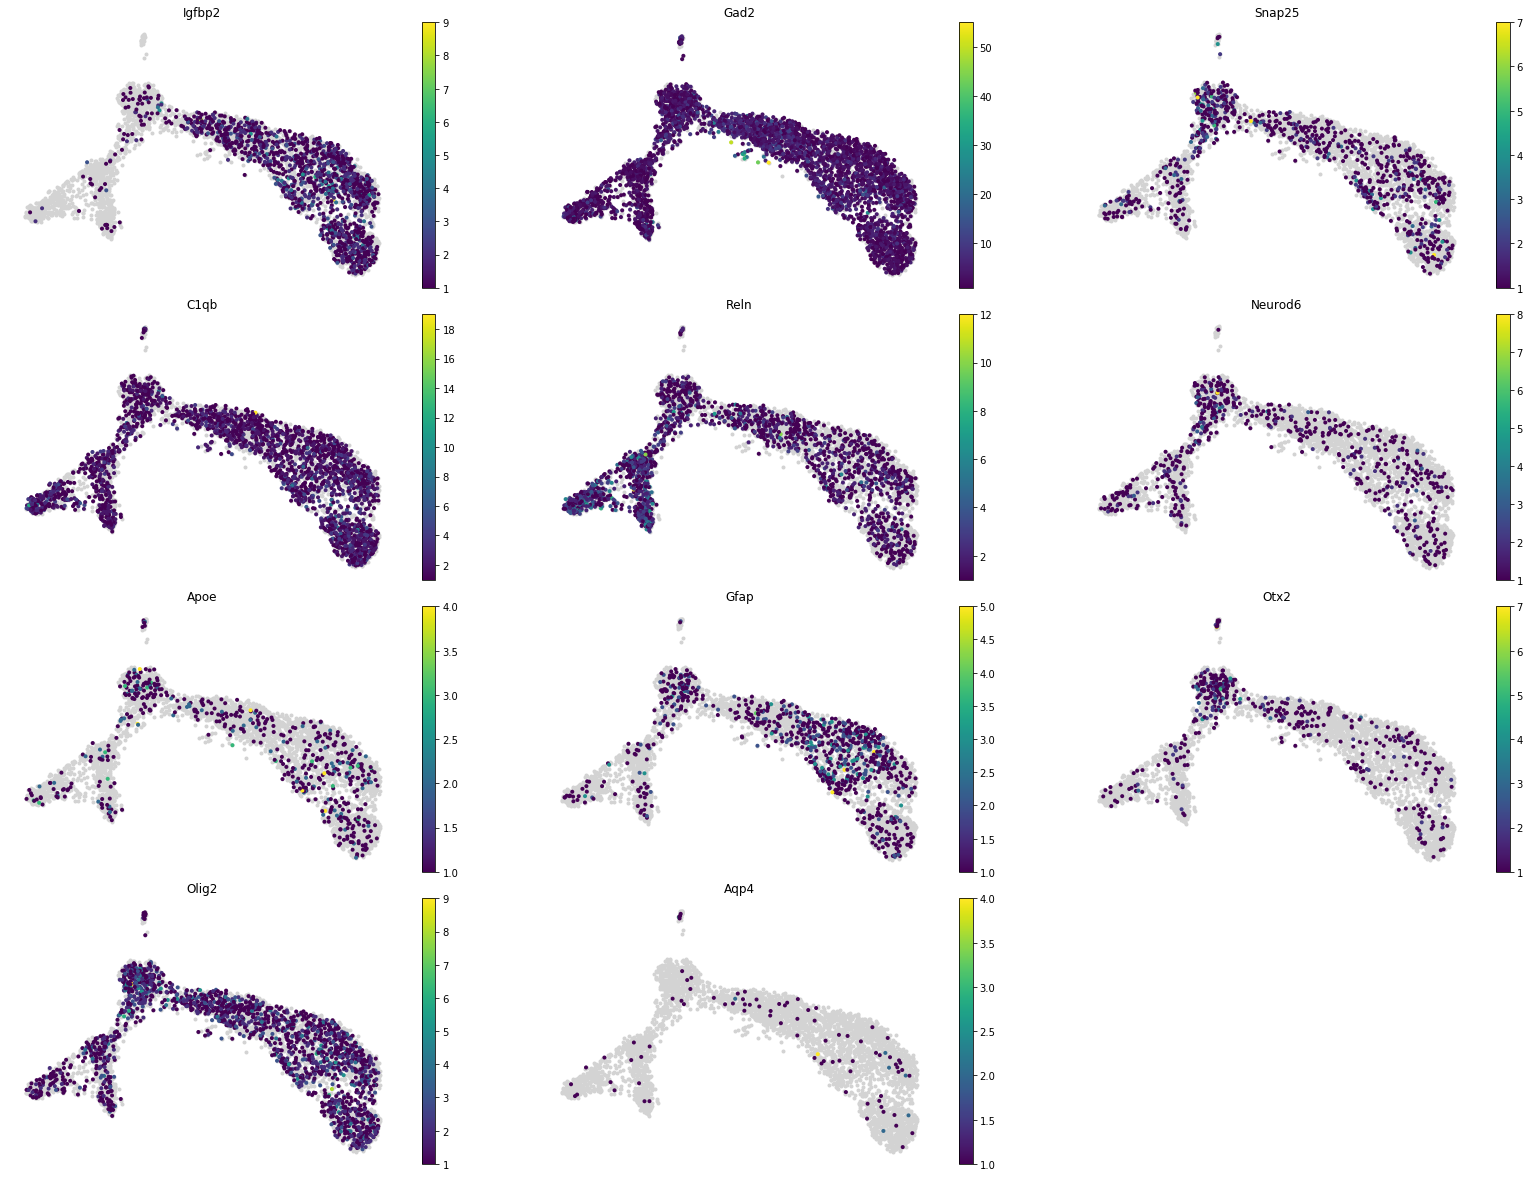

In [142]:
f_plot = f.split('_')[:-1]
f_TSNE = '_'.join(f_plot) + '_genes_tSNE.png'
f_UMAP = '_'.join(f_plot) + '_genes_UMAP.png'

feature_plot(dsg, f_TSNE, dsg.ra['Gene'], embedding = 'TSNE')
feature_plot(dsg, f_UMAP, dsg.ra['Gene'], embedding = 'UMAP')